# Stats for Quasi-symmetry and related Gradient Approximation by SB

### Quadrature basis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import scipy.linalg
import seaborn as sns
from scipy.optimize import fsolve
from jax import numpy as jnp
import jax
from jax import jit, vmap

In [2]:
np.random.seed(1)

In [3]:
def angle_S_Sapprox(N, g, pauli): 
    """
    Returns the angle (in degrees and computed w.r.t. the Frobenius inner product)
    between S(x_bar,p_bar) and U^(-1) @ S(x_bar,p_bar)^T @ U

    N : number of modes
    g : nonlinearity strength
    pauli : pauli matrix used as "U" (choose among 'x','y','z')
    """

    # Parameters:
    J = np.random.randn(N,N) 
    J = (J + J.T)/2
    kappa = np.diag(np.ones(N)) 
    k = np.ones(N)
    x_in = np.random.randn(N)
    p_in = np.random.randn(N)

    # Matrix U for the Quasi-symmetry " S^T ≈ U S U^{-1} "
    sigma_z = np.block([
        [np.eye(N), np.zeros((N,N))],
        [np.zeros((N,N)), -np.eye(N)]
        ])
    sigma_x = np.block([
        [np.zeros((N,N)), np.eye(N)],
        [np.eye(N), np.zeros((N,N))]
        ])    
    sigma_y = np.block([
        [np.zeros((N,N)), -1j * np.eye(N)],
        [1j * np.eye(N), np.zeros((N,N))]
        ])  
    if pauli == 'x':
        U = sigma_x
    elif pauli == 'y':
        U = sigma_y
    elif pauli == 'z':
        U = sigma_z
    else:
        print("Invalid pauli matrix")
        return -1

    # Kerr nonlinearity type ("self", "self" + "cross all-to-all", "self" + "cross between neighbors"):
    # 1) only self-Kerr-nonlinearity
    G = np.eye(N) 

    # 2) cross-Kerr-nonlinearities between (j-1) <-> j <-> (j+1)
    #G = np.zeros((N, N), dtype=int)
    #for i in range(N):
    #    G[i, (i-1) % N] = 1  # Connect to previous node
    #    G[i, (i+1) % N] = 1  # Connect to next node

    # 3) self-Kerr-nonlinearity and all-to-all cross-Kerr_nonlinearity
    #G = np.ones((N,N)) 


    # Find steady state:
    y0 = np.random.rand(2*N)

    def equilibrium(x):
        bar_x = x[:N]
        bar_p = x[N:]
        eq_real = -0.5 * k * bar_x + np.matmul(J, bar_p) + 0.5 * g * bar_p * np.matmul(G, (bar_x**2 + bar_p**2)) - np.sqrt(k) * x_in
        eq_imag = -0.5 * k * bar_p - np.matmul(J, bar_x) - 0.5 * g * bar_x * np.matmul(G, (bar_x**2 + bar_p**2)) - np.sqrt(k) * p_in

        return np.concatenate((eq_real, eq_imag))

    def vector_field(y):
        bar_x, bar_p = y[:N], y[N:]
        eq_real = (-0.5 * k * bar_x + jnp.matmul(J, bar_p) + 0.5 * g * bar_p * jnp.matmul(G, (bar_x**2 + bar_p**2)) - jnp.sqrt(k) * x_in)
        eq_imag = (-0.5 * k * bar_p - jnp.matmul(J, bar_x) - 0.5 * g * bar_x * jnp.matmul(G, (bar_x**2 + bar_p**2)) - jnp.sqrt(k) * p_in)   

        return jnp.concatenate([eq_real, eq_imag]) 

    # Compute the Jacobian using JAX
    jacobian_fn = jax.jacfwd(vector_field)  # Forward-mode derivative

    sol, info, ier, msg = fsolve(equilibrium, y0, full_output=True)

    # Check if it converged (ier == 1 indicates success)
    if ier != 1:
        #print("fsolve failed to converge:", msg)
        return np.inf
    else:
        equilibrium_points = sol

        
    bar_x = equilibrium_points[:N]
    bar_p = equilibrium_points[N:]

    Jac = jacobian_fn(jnp.concatenate([bar_x, bar_p]))

    inv_Jac = np.linalg.inv(Jac)

    k_matrix = np.block([[kappa, np.zeros((N,N))],
                        [np.zeros((N,N)), kappa]])
        
    # Scattering Matrix
    S = np.eye(2*N) + k_matrix**0.5 @ inv_Jac @ k_matrix**0.5
    S_approx = np.linalg.inv(U) @ S.T @ U

    def deg_matrix_angle(A, B):
        """Compute the angle between two real matrices using the Frobenius inner product."""
        inner_product = np.trace(A.T @ B)  # Equivalent to sum(A * B) for Frobenius inner product
        norm_A = np.linalg.norm(A, 'fro')
        norm_B = np.linalg.norm(B, 'fro')

        # Avoid division by zero
        if norm_A == 0 or norm_B == 0:
            raise ValueError("One of the matrices has zero Frobenius norm, angle is undefined.")
        
        cos_theta = inner_product / (norm_A * norm_B)
        
        # Clamp value to avoid numerical errors outside valid range of arccos
        cos_theta = np.clip(cos_theta, -1, 1)
        
        return np.degrees(np.arccos(cos_theta))
    
    return deg_matrix_angle(S, S_approx)


In [ ]:
# Produce statistics

mean_angle_matrix = []
std_angle_matrix = []
mean_perc_matrix = []
std_perc_matrix = []
N_values = np.arange(5,105,5)
g_values = np.arange(0.,1.0, 0.05)
num_iterations = 50

for N in N_values:
    mean_angles = []
    std_angles = []
    for g in g_values:
        angle1 = []
        for _ in range(num_iterations):
            angle1.append( angle_S_Sapprox(N, g, 'x') )

        # Calculate statistics
        mean_a1, std_a1 = np.mean(angle1), np.std(angle1)
        mean_angles.append(mean_a1)
        std_angles.append(std_a1)
    mean_angle_matrix.append(mean_angles)
    std_angle_matrix.append(std_angles)

data_average = np.array(mean_angle_matrix)

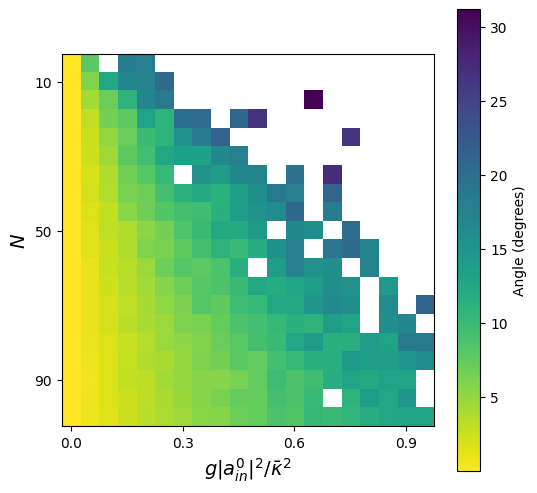

In [6]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(6,6))
# Display the data on the plot
im = ax.imshow(data_average[:,:], cmap='viridis_r')
# Add labels to the x-axis
ax.set_xticks(np.array([0,6,12,18]))
ax.set_xticklabels([f"{val:.1f}" for val in g_values[np.array([0,6,12,18])]])
ax.set_xlabel(r"$g|a^0_{in}|^2/\bar{\kappa}^2$", fontsize=14)

# Add labels to the y-axis
ax.set_yticks(np.array([1,9,17]))
ax.set_yticklabels(np.array(N_values[np.array([1,9,17])]))
ax.set_ylabel(r"$N$", fontsize=14)
# Add a colorbar to the plot
cbar = plt.colorbar(im, ax=ax, label="Angle (degrees)")
plt.show()

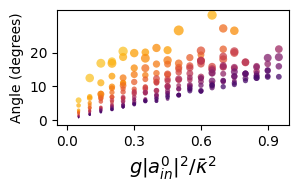

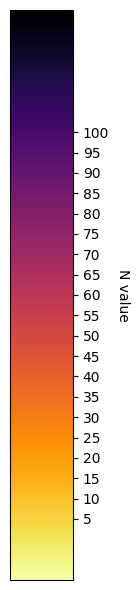

In [7]:
plt.figure(figsize=(3, 1.5))

# Create a colormap
cmap = plt.get_cmap('inferno_r')
norm = plt.Normalize(vmin=-3, vmax=25)  # Normalize based on index_N range
std_angle = np.array(std_angle_matrix)
scale_factor = 3  # Adjust based on how big you want the dots

for index_N in range(1, 20):
    color = cmap(norm(index_N))
    plt.scatter(
        g_values, 
        data_average[index_N, :], 
        label=f"N = {5 + 5 * index_N:.0f}", 
        color=color,
        s=std_angle[index_N, :] * scale_factor,
        alpha=0.75,
        edgecolors='none'
    )
plt.xlabel(r"$g|a^0_{in}|^2/\bar{\kappa}^2$", fontsize=14)
plt.ylabel("Angle (degrees)")
plt.xticks([0., 0.3, 0.6, 0.9])
plt.yticks([0., 10., 20.])

# Setup colormap and normalization
cmap = plt.get_cmap('inferno_r')
norm = mcolors.Normalize(vmin=-3, vmax=25)

# Create scalar mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a figure just for the colorbar
fig, ax = plt.subplots(figsize=(1.5, 6))
cbar = plt.colorbar(sm, cax=ax)

# Set actual N value ticks (N = 5, 10, ..., 100)
index_N_values = np.arange(0, 20)  # 1 to 19
N_values = 5 + 5 * index_N_values
tick_positions = index_N_values  # index_N values are used in norm()

cbar.set_ticks(tick_positions)
cbar.set_ticklabels([str(N) for N in N_values])
cbar.set_label("N value", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

